# Matriz de Correlação e Optuna

Explorando a possibilidade de otimizar a MLP utilizada sobre a matriz de correlação com Optuna, um otimizador de hiperparâmetros Bayesiano. O teste foi realizado utilizando CV, teste e validação. 

Devido ao tamanho do dataset, tivemos dificuldade sobre a capacidade de validação e teste com amostras tão pequenas (1/10 da amostra de treino).

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sys
import os
import time
import torch
import pickle
import parkinson
import optuna

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

In [14]:
RDN = 50
N_CLASSES = 3

# Processamento dos dados

In [15]:
# lendo os arquivos de dados
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns') 
prodomal_data =  parkinson.utils.data.batch_read('../data/Prodomals_columns') 

# selecionando as colunas de atlas AAL3, o atlas de conectividade cerebral
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')
prodomal_atlas_data = parkinson.utils.data.select_atlas_columns(prodomal_data, 'AAL3')

# Geração da matriz de correlação utilizando o método especificado para os grupos
parkinson_correlation_matrix = parkinson.utils.correlation.pearson_correlation(parkinson_atlas_data)
control_correlation_matrix = parkinson.utils.correlation.pearson_correlation(control_atlas_data)
prodomal_correlation_matrix = parkinson.utils.correlation.pearson_correlation(prodomal_atlas_data)

100%|███████████████████████████████████████████████████████████████████| 188/188 [00:03<00:00, 49.08it/s]


- 0: control
- 1: prodomal
- 2: PD

In [16]:
X = parkinson.utils.data.concatenate_data(parkinson_correlation_matrix, control_correlation_matrix, prodomal_correlation_matrix)
y = parkinson.utils.data.concatenate_data([0 for _ in range(len(control_data))], [1 for _ in range(len(prodomal_data))], [2 for _ in range(len(parkinson_data))])
X, y = parkinson.utils.data.filter_data(X, y)

In [17]:
# Dividindo os dados em 60 para treino, 20 para validação e 20 para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RDN, stratify=y, shuffle=True)

# Instanciando OverSampler
ros = RandomOverSampler(random_state=RDN)

## Otimização com Optuna

In [18]:
cross_validation = StratifiedKFold(n_splits=10, shuffle=False)

In [21]:
!cat ../parkinson/NetworkModels/customMLP.py

import torch.nn as nn

class customMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate: float = 0):
        super(customMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [19]:
def objective(trial):
    f1_list = []
    accuracy_list = []
    recall_list = []
    
    # batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
    batch_size = 128
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    hidden_dim = trial.suggest_categorical('hidden_dim', [16, 32, 64, 128, 256, 512])
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5) # From no dropout to 50%
    beta1 = trial.suggest_float('beta1', 0.9, 1)
    beta2 = trial.suggest_float('beta2', 0.9, 1)
    n_epochs = trial.suggest_int('epochs', 0, 80)
    
    for train_index, test_index in cross_validation.split(X_train, y_train):
        X_cv_train = X_train[train_index]
        y_cv_train = y_train[train_index]
        X_cv_train, y_cv_train = ros.fit_resample(X_cv_train, y_cv_train)

        X_cv_test = X_train[test_index]
        y_cv_test = y_train[test_index]
    
        cv_train_loader = parkinson.utils.data.get_torch_dataloader(
            X_cv_train, y_cv_train, batch_size=batch_size, shuffle=True # Usually shuffle train data
        )

        cv_test_loader = parkinson.utils.data.get_torch_dataloader(
            X_cv_test, y_cv_test, batch_size=batch_size, shuffle=False # Don't shuffle test data
        )
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = parkinson.NetworkModels.customMLP(
            input_dim=X_train.shape[1],
            hidden_dim=hidden_dim,
            output_dim=3,
            dropout_rate=dropout_rate
        )
        class_weights = parkinson.utils.data.get_torch_class_weights(y_cv_train)
        
        model.train()
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=learning_rate,
            betas=(beta1,beta2),
            eps=1e-8,
            weight_decay=weight_decay
        )
    
        train_results = parkinson.utils.train.train(
            model=model, 
            train_loader=cv_train_loader, 
            val_loader=None, 
            class_weights=class_weights,
            device=device,
            optimizer=optimizer,
            num_epochs=n_epochs, 
            patience=0,
            lr=learning_rate,
            path=None,
            early_stopping=False
        )
    
        metrics = parkinson.utils.train.evaluate(model, cv_test_loader, device, path=None)
    
        f1_list.append(metrics['f1'])
        accuracy_list.append(metrics['acc'])
        recall_list.append(metrics['recall'])
        
    return np.mean(f1_list) - np.std(f1_list)

In [20]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=250)

[I 2025-07-09 15:33:17,086] A new study created in memory with name: no-name-920d5e83-0874-4c3d-8b85-80174f1a90c4
[W 2025-07-09 15:33:17,112] Trial 0 failed with parameters: {'lr': 0.026437808116773983, 'hidden_dim': 32, 'weight_decay': 1.8881472441925308e-06, 'dropout_rate': 0.26843381250104575, 'beta1': 0.974990773590964, 'beta2': 0.9661086485591707, 'epochs': 44} because of the following error: TypeError("customMLP.__init__() got an unexpected keyword argument 'dropout_rate'").
Traceback (most recent call last):
  File "/home/labic/merlin_codes/dl/Parkinson-Diagnosis-Deeplearning/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_3958458/371505711.py", line 33, in objective
    model = parkinson.NetworkModels.customMLP(
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: customMLP.__init__() got an unexpected keyword argument 'dropout_rate'
[W 2025-07-

TypeError: customMLP.__init__() got an unexpected keyword argument 'dropout_rate'

In [ ]:
best_trial = study.best_trials[0]
print(best_trial.values)
print(best_trial.params)

## Teste

In [ ]:
best_params = best_trial.params

In [23]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, random_state=RDN, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=1/10, random_state=RDN, stratify=y_trainval, shuffle=True)

# Aplicando oversampling no conjunto de treino
ros = RandomOverSampler(random_state=RDN)
X_train, y_train = ros.fit_resample(X_train, y_train)

# Criando DataLoaders
train_loader = parkinson.utils.data.get_torch_dataloader(X_train, y_train, batch_size=best_params['batch_size'])
val_loader = parkinson.utils.data.get_torch_dataloader(X_val, y_val, batch_size=best_params['batch_size'])
test_loader = parkinson.utils.data.get_torch_dataloader(X_test, y_test, batch_size=best_params['batch_size'])

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = parkinson.NetworkModels.customMLP(
    input_dim=X_train.shape[1],
    hidden_dim=best_params['hidden_dim'],
    output_dim=3,
    dropout_rate=best_params['dropout_rate
)
class_weights = parkinson.utils.data.get_torch_class_weights(y_train)

model.train()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=best_params['lr'],
    betas=(best_params['beta1'],best_params['beta2']),
    eps=1e-8,
    weight_decay=best_params['weight_decay']
)

out = parkinson.utils.train.train(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    class_weights=class_weights, 
    device=device,
    optimizer=optimizer,
    num_epochs=best_params['epochs'], 
    patience=best_params['patience'],
    lr=None,
    path="../weights/multimodal"
)

metrics = parkinson.utils.train.evaluate(model, test_loader, device, path="../weights/multimodal")

train-loss: 0.0072  train-acc: 0.9978 | val-loss: 2.8943  val-acc: 0.4595: 

Early stopping at epoch 13


### Análise dos resultados

 Acurácia       F1  Precisão   Recall
 0.390244 0.385468  0.399535 0.390244


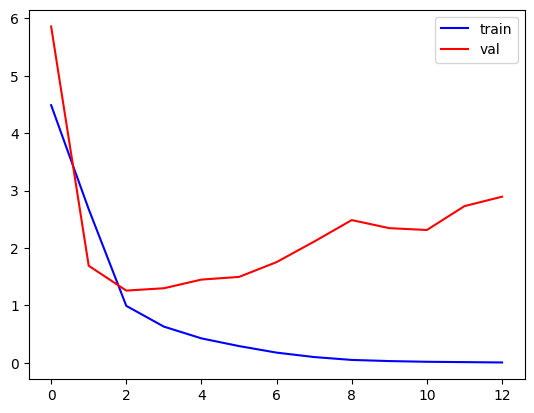

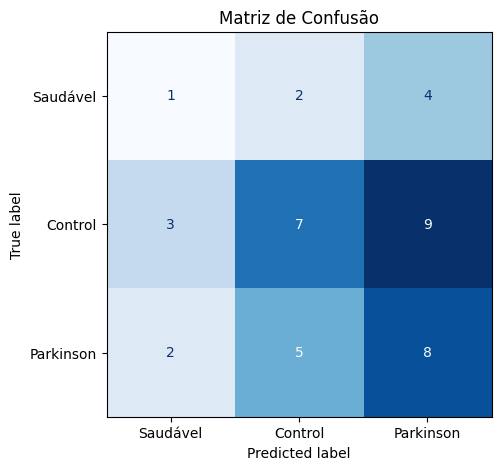

In [25]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics)
fig_loss = parkinson.utils.results.plot_losses(out['train_loss'],out['val_loss'])
fig_cf = parkinson.utils.results.plot_confusion_matrix(metrics['preds'], metrics['labels'], class_names=['Saudável', 'Control','Parkinson'])